In [15]:
# import packages
import pandas as pd
import os
import csv
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.models import ldaseqmodel
import time
from gensim.models.wrappers import DtmModel
import pickle
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [2]:
# read in csv file
all_data = pd.read_csv('./all_data.csv', header=None)
# add columns
all_data.columns = ["year", "title", "article"]
# sort by year
all_data = all_data.sort_values(by=['year'])
# change index
new_index = np.arange(0, len(all_data))
all_data["new_index"] = new_index
all_data = all_data.set_index('new_index')

In [3]:
# construct the stop word list
stopwords = [line.strip() for line in open("stop_words_copy2.txt",encoding='UTF-8').readlines()]

In [4]:
# construct the function that preprocess the text
def preprocess(text):
    '''
    Preprocess the text by tokenizing the string into uni-grams, deleting all 
    numbers, punctuations and stop words. Store the preprocessed sting into 
    a list of words
    
    input: 
        text: text for preprocessing(str)
    output: a list of words
    '''
    result = []
    tokens = gensim.utils.tokenize(text)
    tokens_lst = list(tokens)
    for token in tokens_lst:
        if token not in stopwords:
            result.append(token)
            
    return result

In [5]:
# preprocess the data
processed_df = all_data['article'].map(preprocess)

In [6]:
# prepare Document-Term Matrix for the DTA model 
# Create Dictionaries for unique word counts of each decade
dic_all = corpora.Dictionary(processed_df)

# Create Corpus: Term Document Frequency
corpus_all = [dic_all.doc2bow(text) for text in processed_df]

In [7]:
# set the time slice
all_data[all_data['year']==1958]
# before 60s: 0-35
all_data[all_data['year']==1978]
# before 1979: 36-70
all_data[all_data['year']==1989]
# before 1990: 71-876
all_data[all_data['year']==2003]
# before 2003: 877-1811
time_slice = [71, 806, 935]

In [8]:
# fit the 10-topic model
start = time.time()
ldaseq_10 = ldaseqmodel.LdaSeqModel(corpus=corpus_all, id2word=dic_all, time_slice=time_slice, 
                                    num_topics=10, chain_variance=0.1, random_state=100)
end = time.time()
print(end - start)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


13593.060207366943


In [9]:
# save model
pickle.dump(ldaseq_10, open("ldaseq_model_10_v2.sav", 'wb'))
# check
loaded_model_10 = pickle.load(open("ldaseq_model_10_v2.sav", 'rb'))

In [28]:
# calculate coherence matrix
topics_dtm_10 = ldaseq_10.dtm_coherence(time=1)
cm_DTM_10 = CoherenceModel(topics=topics_dtm_10, corpus=corpus_all, dictionary=dic_all, coherence='u_mass')
print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM_10.get_coherence())

NameError: name 'ldaseq_10' is not defined

In [30]:
# calculate coherence matrix
topics_dtm_10_trial = loaded_model_10.dtm_coherence(time=0)
cm_DTM_10_trial = CoherenceModel(topics=topics_dtm_10_trial, corpus=corpus_all, dictionary=dic_all, coherence='u_mass')
print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM_10_trial.get_coherence())

U_mass topic coherence
DTM Python coherence is -1.3667103629273132


In [8]:
# check
loaded_model_10 = pickle.load(open("ldaseq_model_10_v2.sav", 'rb'))

In [9]:
doc_topic_10 = []
for doc_num in range(len(all_data)):
    doc = loaded_model_10.doc_topics(doc_num)
    doc_topic_10.append(doc)
topic_df_10 = pd.DataFrame(doc_topic_10, columns=['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10'])

In [13]:
topic_com_df_10 = pd.concat([all_data, topic_df_10], axis=1, sort=False)
grouped_df_10 = topic_com_df_10.groupby(['year']).sum().reset_index()

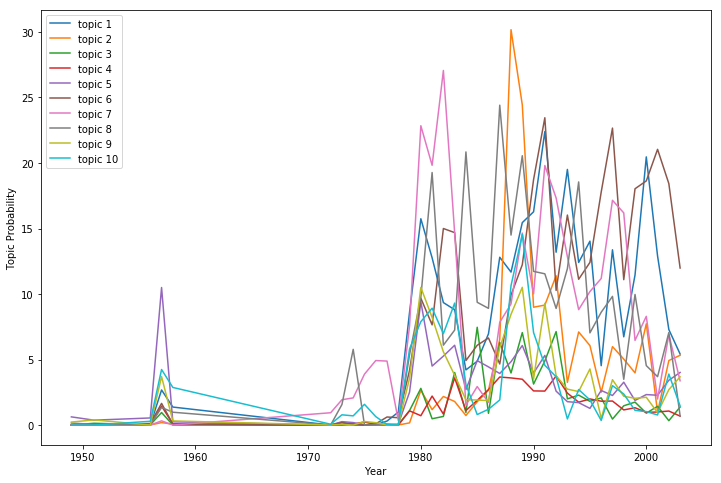

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(grouped_df_10['year'], grouped_df_10['t1'], label='topic 1')
plt.plot(grouped_df_10['year'], grouped_df_10['t2'], label='topic 2')
plt.plot(grouped_df_10['year'], grouped_df_10['t3'], label='topic 3')
plt.plot(grouped_df_10['year'], grouped_df_10['t4'], label='topic 4')
plt.plot(grouped_df_10['year'], grouped_df_10['t5'], label='topic 5')
plt.plot(grouped_df_10['year'], grouped_df_10['t6'], label='topic 6')
plt.plot(grouped_df_10['year'], grouped_df_10['t7'], label='topic 7')
plt.plot(grouped_df_10['year'], grouped_df_10['t8'], label='topic 8')
plt.plot(grouped_df_10['year'], grouped_df_10['t9'], label='topic 9')
plt.plot(grouped_df_10['year'], grouped_df_10['t10'], label='topic 10')
plt.xlabel("Year")
plt.ylabel("Topic Probability")
plt.legend(loc='best')
plt.show()

In [17]:
# print the first period (pre 1979)
first_period = loaded_model_10.print_topics(time=0)
first_period

[[('人口', 0.06010887409618434),
  ('我国', 0.03872458942507607),
  ('问题', 0.020699726952808962),
  ('社会主义', 0.01811152310505054),
  ('发展', 0.017383456941339286),
  ('生产', 0.013002658610271898),
  ('人', 0.012434759460323287),
  ('建设', 0.01176558411324416),
  ('人民', 0.011022674042836677),
  ('增长', 0.009607774241259458),
  ('中国', 0.009335996957101378),
  ('社会', 0.008750139498317771),
  ('劳动力', 0.007422782138632934),
  ('提高', 0.00701830762864143),
  ('控制', 0.0063410512396954635),
  ('新', 0.006312111469867188),
  ('经济', 0.006232880973768488),
  ('解决', 0.0062293062294012345),
  ('速度', 0.006182027617986107),
  ('研究', 0.005625268042839646)],
 [('计划生育', 0.024472527440390225),
  ('人口', 0.02217762722117484),
  ('工作', 0.014361554679908559),
  ('人', 0.012402000608887473),
  ('管理', 0.012064558205380145),
  ('流动', 0.010300092385055333),
  ('超生', 0.009757631909720699),
  ('万', 0.008921962775579727),
  ('生育', 0.008004871193903047),
  ('出生', 0.007555172034193745),
  ('部门', 0.007400944278520753),
  ('统计', 0

In [18]:
# print the second period
# print topics of the second time period (1980s)
second_period = loaded_model_10.print_topics(time=1)
second_period

[[('人口', 0.07466196132005415),
  ('我国', 0.027845922285008883),
  ('增长', 0.018690921991764285),
  ('发展', 0.015493100345159825),
  ('控制', 0.012159725990138147),
  ('问题', 0.011654614801310036),
  ('经济', 0.009963843837953078),
  ('生产', 0.00808569808148841),
  ('社会', 0.007270452462101842),
  ('人', 0.007160499068580213),
  ('提高', 0.006824606948016542),
  ('中国', 0.006475306042288208),
  ('水平', 0.00616863667041788),
  ('亿', 0.005841137209695917),
  ('人民', 0.005099838034864441),
  ('出生', 0.004999673173132419),
  ('国家', 0.0047977633739000655),
  ('平均', 0.004624301462381327),
  ('劳动力', 0.004428011030797875),
  ('生育', 0.0044087971809550364)],
 [('计划生育', 0.030929036250876295),
  ('人口', 0.01958534644467152),
  ('工作', 0.01382185230901327),
  ('人', 0.012465052149374063),
  ('超生', 0.011146725944680353),
  ('管理', 0.010766068493186943),
  ('流动', 0.010539434396732293),
  ('生育', 0.008648640869938686),
  ('万', 0.008487892423466049),
  ('部门', 0.006900952624974388),
  ('出生', 0.006627658059423112),
  ('人员', 0.

In [19]:
# print topics of the third time period (1990s)
third_period = loaded_model_10.print_topics(time=2)
third_period

[[('人口', 0.07995878461903436),
  ('我国', 0.01799477907359178),
  ('发展', 0.01712772892253642),
  ('中国', 0.015937723767703478),
  ('社会', 0.011362723139520043),
  ('问题', 0.011263934422014909),
  ('增长', 0.010703085830796422),
  ('经济', 0.009662093390088545),
  ('水平', 0.008606771325783155),
  ('控制', 0.008280681178713724),
  ('国家', 0.007245846615333648),
  ('人', 0.00719457996379047),
  ('计划生育', 0.007104205976037221),
  ('提高', 0.007039882800644492),
  ('全国', 0.006927216274883572),
  ('低', 0.006230944790271971),
  ('生育', 0.005602682170760986),
  ('素质', 0.0055148069692211215),
  ('文化', 0.005452175044416959),
  ('教育', 0.004818052265827544)],
 [('人口', 0.03233933246731611),
  ('流动', 0.019313874765082034),
  ('管理', 0.017062160052183462),
  ('计划生育', 0.015465508198658806),
  ('工作', 0.013630183638051015),
  ('人', 0.012294243021877196),
  ('计生', 0.011347296135382432),
  ('部门', 0.008009792876556189),
  ('万', 0.007659750253191893),
  ('普查', 0.007240644679832567),
  ('出生', 0.006265872580232185),
  ('统计', 0.

In [20]:
# evolution of 5th topic
fifth_topic = loaded_model_10.print_topic_times(topic=4) 
fifth_topic

[[('避孕', 0.029590050863940915),
  ('节育', 0.013313637298395936),
  ('方法', 0.010282704993919114),
  ('生育', 0.010078064564726033),
  ('工作', 0.009094890219443897),
  ('健康', 0.008148298874907237),
  ('人工流产', 0.008141311993193822),
  ('卫生', 0.00764604061851357),
  ('宣传', 0.007283601857019767),
  ('手术', 0.007033384137372314),
  ('指导', 0.006856987701025736),
  ('进行', 0.006613954846168318),
  ('研究', 0.0064639925239136),
  ('妇女', 0.00618279342123105),
  ('节制', 0.006151567121719927),
  ('人', 0.006019995728263168),
  ('人民', 0.005650846407619254),
  ('问题', 0.005643584332346928),
  ('技术', 0.0055683768879686985),
  ('科学', 0.005117844150242455)],
 [('节育', 0.02077900774574559),
  ('手术', 0.018935414647919934),
  ('避孕', 0.017337625161780886),
  ('技术', 0.013415856465952171),
  ('计划生育', 0.013317632076119188),
  ('研究', 0.010833810084304991),
  ('健康', 0.007723278236549549),
  ('卫生', 0.0076665245730574575),
  ('人员', 0.007171504125087056),
  ('妇女', 0.006801057476314158),
  ('方法', 0.006719473672231145),
  ('医院'

In [21]:
# evolution of 8th topic
eightth_topic = loaded_model_10.print_topic_times(topic=7) 
eightth_topic

[[('人口', 0.05135537218147716),
  ('国家', 0.016534025351927877),
  ('世界', 0.014893243993870408),
  ('问题', 0.014383627976806364),
  ('人民', 0.01304529694249259),
  ('增长', 0.01167773065862936),
  ('经济', 0.011043621475882682),
  ('会议', 0.010334824439461208),
  ('发展', 0.010136266221118037),
  ('代表', 0.007255769955714061),
  ('政策', 0.0065585739840321195),
  ('中国', 0.005873941406738694),
  ('人', 0.005839564251529007),
  ('指出', 0.005711412431769819),
  ('各国', 0.005016697670571934),
  ('国际', 0.004689517971752575),
  ('增加', 0.0045818120468028335),
  ('社会', 0.004537865931693441),
  ('发言', 0.004286927379613607),
  ('帝国主义', 0.004243050284430755)],
 [('人口', 0.08168282497747696),
  ('增长', 0.019116872404833143),
  ('世界', 0.017572818213213798),
  ('发展', 0.015108940043043329),
  ('国家', 0.014230614057630332),
  ('问题', 0.011455993405160196),
  ('控制', 0.008214626980600508),
  ('经济', 0.008068595341278075),
  ('亚洲', 0.007853462251029765),
  ('联合国', 0.007846955931323174),
  ('亿', 0.007788184839193163),
  ('人', 

In [22]:
# evolution of 7th topic
seventh_topic = loaded_model_10.print_topic_times(topic=6) 
seventh_topic

[[('计划生育', 0.05161894458410631),
  ('工作', 0.037213592287912066),
  ('思想', 0.010005226746716011),
  ('群众', 0.008516950660792845),
  ('领导', 0.008177627447343376),
  ('实行', 0.00808180593334157),
  ('晚婚', 0.007718661145934822),
  ('主席', 0.007042483991675122),
  ('大队', 0.007017058740228998),
  ('革命', 0.00665498535164828),
  ('抓', 0.006477249307574669),
  ('人口', 0.006308849568775681),
  ('宣传', 0.0061763881350759015),
  ('公社', 0.006096516091697104),
  ('开展', 0.006072665838202192),
  ('措施', 0.005921584066186597),
  ('计划', 0.005907403274275764),
  ('干部', 0.0056275473565551475),
  ('新', 0.005544198957551796),
  ('妇女', 0.005335694982204281)],
 [('计划生育', 0.043374850362518515),
  ('工作', 0.031338492456907056),
  ('人口', 0.015347901836085878),
  ('干部', 0.013333457043842221),
  ('群众', 0.010712375500130326),
  ('抓', 0.008564988523638413),
  ('县', 0.008482808084646076),
  ('措施', 0.00846126808624451),
  ('生产', 0.00792865812555899),
  ('实行', 0.007692317467360365),
  ('增长率', 0.007457797787829063),
  ('领导', 

In [23]:
# evolution of 2nd topic
second_topic = loaded_model_10.print_topic_times(topic=1) 
second_topic

[[('计划生育', 0.024472527440390225),
  ('人口', 0.02217762722117484),
  ('工作', 0.014361554679908559),
  ('人', 0.012402000608887473),
  ('管理', 0.012064558205380145),
  ('流动', 0.010300092385055333),
  ('超生', 0.009757631909720699),
  ('万', 0.008921962775579727),
  ('生育', 0.008004871193903047),
  ('出生', 0.007555172034193745),
  ('部门', 0.007400944278520753),
  ('统计', 0.006981852263793089),
  ('人员', 0.005753601471439521),
  ('干部', 0.005529185733895339),
  ('计划', 0.005498421666561182),
  ('外', 0.005320829338770586),
  ('调查', 0.005225621406447822),
  ('登记', 0.005204603276409282),
  ('户口', 0.004949682418648927),
  ('严重', 0.003954609825433314)],
 [('计划生育', 0.030929036250876295),
  ('人口', 0.01958534644467152),
  ('工作', 0.01382185230901327),
  ('人', 0.012465052149374063),
  ('超生', 0.011146725944680353),
  ('管理', 0.010766068493186943),
  ('流动', 0.010539434396732293),
  ('生育', 0.008648640869938686),
  ('万', 0.008487892423466049),
  ('部门', 0.006900952624974388),
  ('出生', 0.006627658059423112),
  ('人员', 0.

In [24]:
# evolution of 1st topic
first_topic = loaded_model_10.print_topic_times(topic=0) 
first_topic

[[('人口', 0.06010887409618434),
  ('我国', 0.03872458942507607),
  ('问题', 0.020699726952808962),
  ('社会主义', 0.01811152310505054),
  ('发展', 0.017383456941339286),
  ('生产', 0.013002658610271898),
  ('人', 0.012434759460323287),
  ('建设', 0.01176558411324416),
  ('人民', 0.011022674042836677),
  ('增长', 0.009607774241259458),
  ('中国', 0.009335996957101378),
  ('社会', 0.008750139498317771),
  ('劳动力', 0.007422782138632934),
  ('提高', 0.00701830762864143),
  ('控制', 0.0063410512396954635),
  ('新', 0.006312111469867188),
  ('经济', 0.006232880973768488),
  ('解决', 0.0062293062294012345),
  ('速度', 0.006182027617986107),
  ('研究', 0.005625268042839646)],
 [('人口', 0.07466196132005415),
  ('我国', 0.027845922285008883),
  ('增长', 0.018690921991764285),
  ('发展', 0.015493100345159825),
  ('控制', 0.012159725990138147),
  ('问题', 0.011654614801310036),
  ('经济', 0.009963843837953078),
  ('生产', 0.00808569808148841),
  ('社会', 0.007270452462101842),
  ('人', 0.007160499068580213),
  ('提高', 0.006824606948016542),
  ('中国', 0.0

In [25]:
# evolution of 6th topic
sixth_topic = loaded_model_10.print_topic_times(topic=5) 
sixth_topic

[[('工作', 0.06668764755099879),
  ('群众', 0.026821077758815),
  ('宣传', 0.02435441285960479),
  ('计划生育', 0.02103835390828721),
  ('全国', 0.01313076270905257),
  ('会议', 0.011546513024464697),
  ('加强', 0.009719258506248912),
  ('计划', 0.009303923934361436),
  ('领导', 0.009285277112950472),
  ('经验', 0.00922153500532245),
  ('代表', 0.008743759981256989),
  ('国家', 0.007972956934384682),
  ('人民', 0.007929489805374328),
  ('各级', 0.007734230421067068),
  ('要求', 0.00768810924516511),
  ('开展', 0.006270743141490087),
  ('人口', 0.006020336261560646),
  ('继续', 0.005893738544374677),
  ('进一步', 0.005853492749227726),
  ('委员会', 0.00577409752803348)],
 [('计划生育', 0.06994529181612273),
  ('工作', 0.04757060668528932),
  ('全国', 0.013581199396913723),
  ('群众', 0.013474252835284447),
  ('宣传', 0.012548315846361884),
  ('国家', 0.008511780439650339),
  ('人口', 0.007973094152729792),
  ('会议', 0.007815151446927387),
  ('控制', 0.007390314221414177),
  ('政策', 0.0068403444493134544),
  ('领导', 0.006382041375517104),
  ('实行', 0.0